<a href="https://colab.research.google.com/github/theguyindark/password-scoring-ML/blob/main/Password_Scoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Password Stregth Scoring**

# **Load Dataset**

In [ ]:
!pip install opendatasets
!pip install tensorflow

In [ ]:
import opendatasets as od
od.download ("https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: elmoose
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset


100%|██████████| 5.01M/5.01M [00:00<00:00, 492MB/s]

# **Data Cleaning**

In [ ]:
import pandas as pd
data = pd.read_csv("/content/password-strength-classifier-dataset/data.csv", sep=',', on_bad_lines='skip')

In [ ]:
data = data.dropna()
data = data.drop_duplicates()

In [ ]:
data.head()

,password,strength
0,kzde5577,1
1,kino3434,1
2,visi7k1yr,1
3,megzy123,1
4,lamborghin1,1


# **Feature Engineering**

In [ ]:
import re

#Count length
data['length'] = data['password'].apply(len)

# Count digits
data['num_digits'] = data['password'].apply(lambda x: len(re.findall(r'\d', x)))

# Count uppercase letters
data['num_upper'] = data['password'].apply(lambda x: len(re.findall(r'[A-Z]', x)))

# Count lowercase letters
data['num_lower'] = data['password'].apply(lambda x: len(re.findall(r'[a-z]', x)))

# Count special characters
data['num_special'] = data['password'].apply(lambda x: len(re.findall(r'[^a-zA-Z0-9]', x)))

In [ ]:
def char_variety(password):
    has_lower = bool(re.search(r'[a-z]', password))
    has_upper = bool(re.search(r'[A-Z]', password))
    has_digit = bool(re.search(r'\d', password))
    has_special = bool(re.search(r'[^a-zA-Z0-9]', password))  #Includes all characters except alphanumeric:
    return sum([has_lower, has_upper, has_digit, has_special])

data['char_variety_score'] = data['password'].apply(char_variety)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669639 entries, 0 to 669639
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   password            669639 non-null  object
 1   strength            669639 non-null  int64 
 2   length              669639 non-null  int64 
 3   num_digits          669639 non-null  int64 
 4   num_upper           669639 non-null  int64 
 5   num_lower           669639 non-null  int64 
 6   num_special         669639 non-null  int64 
 7   char_variety_score  669639 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 46.0+ MB


In [ ]:
import math
import re
import pandas as pd

# Function to load dictionary words from a file
def load_dictionary(file_path):
    """Load dictionary words from a file."""
    try:
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as file:
            return [line.strip() for line in file]
    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return []
    except Exception as e:
        print(f"An error occurred while loading the dictionary: {e}")
        return []

# Load dictionary words
dictionary_words = load_dictionary('/content/common-passwords.txt')

# Normalize substitutions to handle leetspeak
def normalize_substitutions(password):
    substitution_map = {'@': 'a', '$': 's', '1': 'i', '0': 'o', '3': 'e', '+': 't'}
    if not password or not isinstance(password, str):
        return ''
    return ''.join([substitution_map.get(c.lower(), c) for c in password])

# Calculate entropy based on the character set and password length
def calculate_entropy(password):
    if not password or not isinstance(password, str):
        return 0

    normalized_password = normalize_substitutions(password)
    char_set_size = 0

    # Determine the effective character set size dynamically
    if re.search(r'[a-z]', normalized_password):
        char_set_size += 26  # Lowercase letters
    if re.search(r'[A-Z]', normalized_password):
        char_set_size += 26  # Uppercase letters
    if re.search(r'\d', normalized_password):
        char_set_size += 10  # Digits
    if re.search(r'[^a-zA-Z0-9]', normalized_password):
        char_set_size += 32  # Special characters

    if char_set_size == 0:
        return 0  # No entropy for empty or invalid passwords

    return len(normalized_password) * math.log2(char_set_size)

# Detect patterns (sequences and repeated characters)
def detect_pattern(password):
    """Detect weak sequences and repeated patterns in a password."""
    if not password or not isinstance(password, str):
        return 0

    normalized = normalize_substitutions(password)

    # Detect sequences
    for i in range(len(normalized) - 2):
        # Check for numerical or alphabetical sequences
        if (
            ord(normalized[i+1]) == ord(normalized[i]) + 1 and
            ord(normalized[i+2]) == ord(normalized[i]) + 2
        ):
            return 1  # Sequence detected

    # Detect repeated characters or digits
    if re.search(r'(.)\1{2,}', normalized):  # Three or more repeated characters
        return 1
    if re.search(r'(\d)\1{2,}', normalized):  # Three or more repeated digits
        return 1

    return 0

# Detect dictionary words
def detect_dictionary_words(password, dictionary_words):
    """Detect dictionary words in the password."""
    if not password or not isinstance(password, str):
        return 0

    normalized = normalize_substitutions(password)
    for word in dictionary_words:
        if word in normalized:
            return 1
    return 0

# Classify password strength
def classify_strength(row):
    entropy = row['entropy']
    penalties = (
        row['pattern_detect'] * 15 +
        row['dictionary_word'] * 20
    )
    entropy -= penalties

    # Classification thresholds
    if row['length'] < 8 or entropy < 40:
        return 0  # Weak
    elif 8 <= row['length'] <= 12 and 40 <= entropy < 80:
        return 1  # Medium
    elif row['length'] > 12 and entropy >= 80:
        return 2  # Strong
    return 0

# Apply transformations to the dataset
data['length'] = data['password'].apply(len)
data['char_variety_score'] = data['password'].apply(lambda x: sum([
    bool(re.search(r'[A-Z]', x)),
    bool(re.search(r'[a-z]', x)),
    bool(re.search(r'\d', x)),
    bool(re.search(r'[^a-zA-Z0-9]', x))
]))
data['entropy'] = data['password'].apply(calculate_entropy)
data['pattern_detect'] = data['password'].apply(detect_pattern)
data['dictionary_word'] = data['password'].apply(
    lambda x: detect_dictionary_words(x, dictionary_words)
)
data['strength'] = data.apply(classify_strength, axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 669639 entries, 0 to 669639
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   password            669639 non-null  object 
 1   strength            669639 non-null  int64  
 2   length              669639 non-null  int64  
 3   num_digits          669639 non-null  int64  
 4   num_upper           669639 non-null  int64  
 5   num_lower           669639 non-null  int64  
 6   num_special         669639 non-null  int64  
 7   char_variety_score  669639 non-null  int64  
 8   entropy             669639 non-null  float64
 9   pattern_detect      669639 non-null  int64  
 10  dictionary_word     669639 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 61.3+ MB


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix
import pandas as pd

# Ensure no missing or empty passwords
data = data.dropna(subset=['password'])  # Drop rows with missing passwords
data = data[data['password'].str.len() > 0]  # Drop rows with empty passwords

# TfidfVectorizer with character-level n-grams
vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(1, 2), min_df=5, lowercase=True)

# Transform passwords into n-grams
password_list = data['password'].tolist()
vectorizer.fit(password_list)
X_ngrams = vectorizer.transform(password_list)

# Normalize and transform manual features
scaler = StandardScaler()
X_manual = scaler.fit_transform(data[['length', 'num_upper', 'char_variety_score', 'entropy', 'pattern_detect']])
X_manual = csr_matrix(X_manual)

# Combine manual features and n-grams
X_combined = hstack([X_manual, X_ngrams])

# Validate shapes
print("Shape of manual features:", X_manual.shape)
print("Shape of n-gram features:", X_ngrams.shape)
print("Shape of combined features:", X_combined.shape)

# Inspect sample n-grams and manual features
print("Sample n-grams:", vectorizer.get_feature_names_out()[:10])
print("Sample manual features (scaled):", X_manual[:5].toarray())

Shape of manual features: (669639, 5)
Shape of n-gram features: (669639, 2554)
Shape of combined features: (669639, 2559)
Sample n-grams: [' ' ' !' ' -' ' .' ' 0' ' 1' ' 2' ' 3' ' 4' ' 5']
Sample manual features (scaled): [[-0.70627019 -0.34746195 -0.36593538 -0.61724146 -0.24769055]
 [-0.70627019 -0.34746195 -0.36593538 -0.61724146 -0.24769055]
 [-0.35165417 -0.34746195 -0.36593538 -0.33761146 -0.24769055]
 [-0.70627019 -0.34746195 -0.36593538 -0.61724146 -0.24769055]
 [ 0.35757786 -0.34746195 -0.36593538 -0.05767928  4.03729577]]


# **Feature Selection Method**

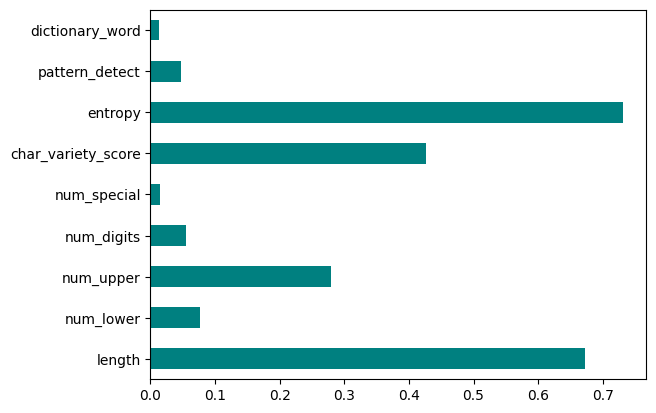

In [ ]:
import re
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import matplotlib.pyplot as plt
%matplotlib inline


X = data[['length', 'num_lower', 'num_upper', 'num_digits', 'num_special','char_variety_score', 'entropy', 'pattern_detect', 'dictionary_word']]  # Features
Y = data['strength']  # Target variable


importances = mutual_info_classif(X, Y)
feat_importances = pd.Series(importances, X.columns) # Use X.columns for feature names
feat_importances.plot(kind='barh', color='teal')
plt.show()

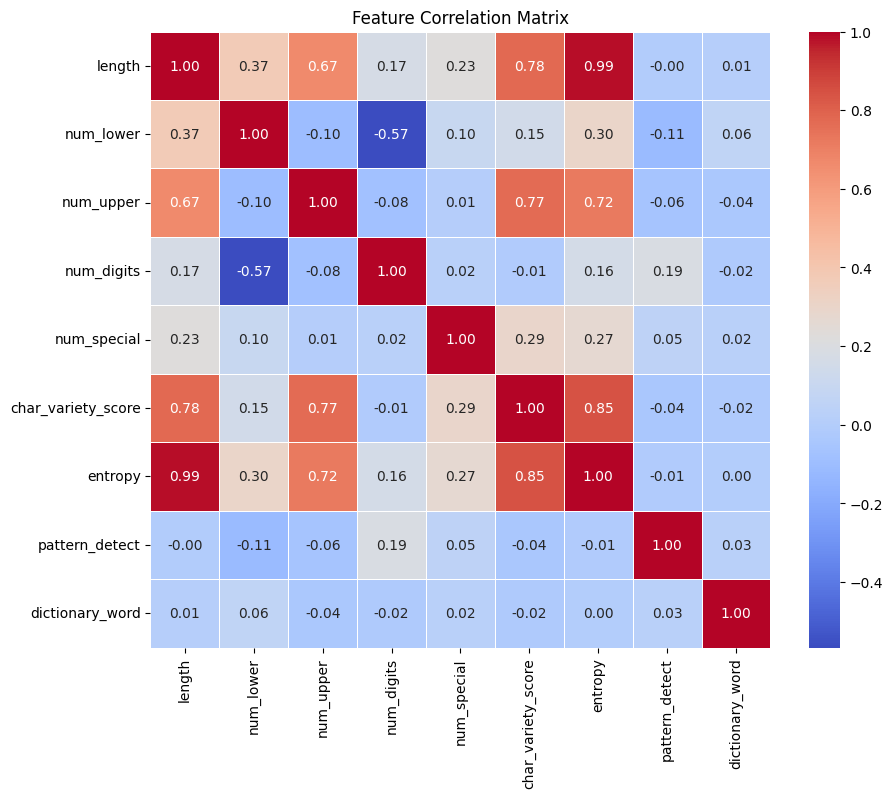

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

# Encode 'strength' column
encoder = OrdinalEncoder()
data['strength'] = encoder.fit_transform(data[['strength']])

# Recalculate correlation matrix
corr_matrix = data[['length', 'num_lower', 'num_upper', 'num_digits', 'num_special','char_variety_score', 'entropy', 'pattern_detect', 'dictionary_word']].corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

# Define features and target variable
X = data[['length', 'num_lower', 'num_upper', 'num_digits', 'num_special','char_variety_score', 'entropy', 'pattern_detect', 'dictionary_word']]
y = data['strength']

# Apply SelectKBest with ANOVA F-value
selector = SelectKBest(score_func=f_classif, k='all')  # Choose 'k' to select top features
X_selected = selector.fit_transform(X, y)

# Show feature scores
feature_scores = pd.DataFrame({'Feature': X.columns, 'Score': selector.scores_})
print(feature_scores.sort_values(by='Score', ascending=False))

              Feature         Score
5  char_variety_score  3.223676e+06
6             entropy  1.014910e+06
2           num_upper  7.844366e+05
0              length  6.439940e+05
7      pattern_detect  4.166826e+04
4         num_special  1.174658e+04
8     dictionary_word  1.115577e+04
3          num_digits  9.830496e+03
1           num_lower  8.681491e+03


In [ ]:
# Import the necessary class
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

# Get feature importance
importance = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
print(feature_importance.sort_values(by='Importance', ascending=False))

              Feature  Importance
6             entropy    0.404026
0              length    0.274289
5  char_variety_score    0.108754
7      pattern_detect    0.097559
2           num_upper    0.059024
8     dictionary_word    0.029033
1           num_lower    0.014307
3          num_digits    0.012453
4         num_special    0.000554


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

# Initialize model for feature ranking
model = RandomForestClassifier()

# Perform RFE
rfe = RFE(estimator=model, n_features_to_select=5)  # Adjust n_features_to_select based on preference
X_rfe = rfe.fit_transform(X, y)

# Check which features were selected
selected_features = X.columns[rfe.support_]
print("Selected features:", selected_features)

Selected features: Index(['length', 'num_upper', 'char_variety_score', 'entropy',
       'pattern_detect'],
      dtype='object')


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Assuming 'selected_features' contains the 5 features i choose
selected_features = ['length', 'num_upper', 'char_variety_score', 'entropy', 'pattern_detect']

# Define the features and target
X = data[selected_features]  # Features
y = data['strength']  # Target variable

# Train a Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X, y)

RandomForestClassifier()

In [ ]:
from sklearn.model_selection import cross_val_score, train_test_split

# Initialize model
rf_model = RandomForestClassifier()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)  # Can adjust test_size and random_state as needed

# Perform cross-validation (5-fold by default) on the training data
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')

# Print mean score across the folds
print(f"Cross-validation accuracy: {cross_val_scores.mean()}")

Cross-validation accuracy: 0.9911335271856616


Class distribution in the target variable:
Counter({1.0: 432151, 0.0: 156745, 2.0: 80743})


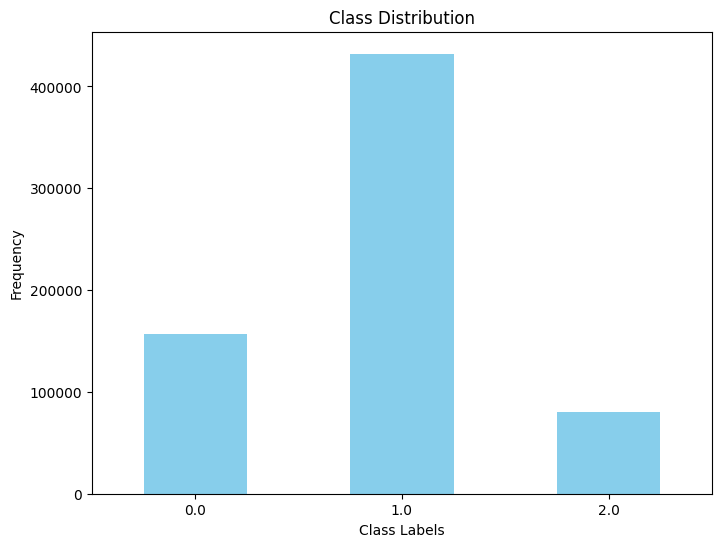

In [ ]:
from collections import Counter
import pandas as pd

# Assuming 'y' is your target variable (e.g., the 'strength' column)
print("Class distribution in the target variable:")
print(Counter(y))  # Displays the count of each class

# Visualize the class imbalance
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(8, 6))
pd.Series(y).value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Class Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()


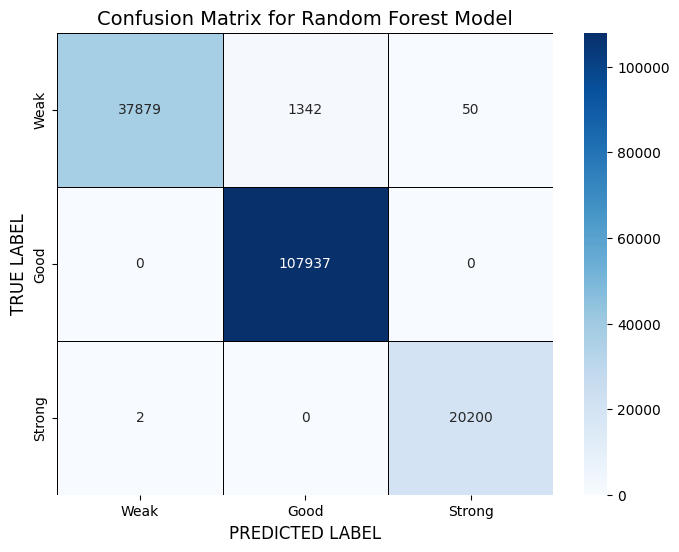

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

selected_features = ['length', 'num_upper', 'char_variety_score', 'entropy', 'pattern_detect']
X = data[selected_features]  # Features
y = data['strength']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf_model = RandomForestClassifier() # Reinitialize rf_model
rf_model.fit(X_train, y_train)

# Generate predictions on the test set
rf_predictions = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# Define labels for the confusion matrix
x_axis_labels = ["Weak", "Good", "Strong"]  # Adjust labels as per your classes
y_axis_labels = ["Weak", "Good", "Strong"]

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6), facecolor='w')  # Set figure size and background color
sns.heatmap(cm, annot=True, linewidths=0.5, linecolor="black", fmt="d",
            cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)

# Add labels and title
plt.xlabel("PREDICTED LABEL", fontsize=12)
plt.ylabel("TRUE LABEL", fontsize=12)
plt.title("Confusion Matrix for Random Forest Model", fontsize=14)

# Display the plot
plt.show()

# **Train, Test And Split**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Define features and target
X = data[['length', 'num_upper', 'char_variety_score', 'entropy', 'pattern_detect']]
y = data['strength']

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, train_size=1/3, random_state=42, stratify=y_temp)

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)

# Evaluate on test set
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)

# Optional: Detailed classification report
print("Classification Report:\n", classification_report(y_test, y_test_pred))

Validation Accuracy: 0.9916970312406667
Test Accuracy: 0.9911892957409951
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     31349
         1.0       0.99      1.00      0.99     86430
         2.0       1.00      1.00      1.00     16149

    accuracy                           0.99    133928
   macro avg       0.99      0.99      0.99    133928
weighted avg       0.99      0.99      0.99    133928



In [ ]:
# Total number of samples
total_samples = len(data)

# Calculate expected number of samples for each split
train_size = total_samples * 0.7
val_size = total_samples * 0.1
test_size = total_samples * 0.2

# Print the expected sizes
print(f"Expected training set size: {train_size}")
print(f"Expected validation set size: {val_size}")
print(f"Expected test set size: {test_size}")

# Also print actual sizes
print(f"Actual training set size: {X_train.shape[0]}")
print(f"Actual validation set size: {X_val.shape[0]}")
print(f"Actual test set size: {X_test.shape[0]}")

Expected training set size: 468747.3
Expected validation set size: 66963.90000000001
Expected test set size: 133927.80000000002
Actual training set size: 468747
Actual validation set size: 66964
Actual test set size: 133928


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Initialize models
rf_model = RandomForestClassifier()  # Random Forest

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

x = data[selected_features]
y = data['strength']

rf_model.fit(X_train, y_train)

# Make predictions on the validation set
y_pred = rf_model.predict(X_val[selected_features])

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)  # Changed: y_true to y_val
precision = precision_score(y_val, y_pred, average='weighted')  # Changed: y_true to y_val
recall = recall_score(y_val, y_pred, average='weighted')  # Changed: y_true to y_val
f1 = f1_score(y_val, y_pred, average='weighted')  # Changed: y_true to y_val

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Create confusion matrix
conf_matrix = confusion_matrix(y_val, y_pred)  # Changed: y_true to y_val
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9916820978436175
Precision: 0.9917778622581221
Recall: 0.9916820978436175
F1-score: 0.9916313789084013
Confusion Matrix:
[[15119   527    29]
 [    0 43215     0]
 [    1     0  8073]]


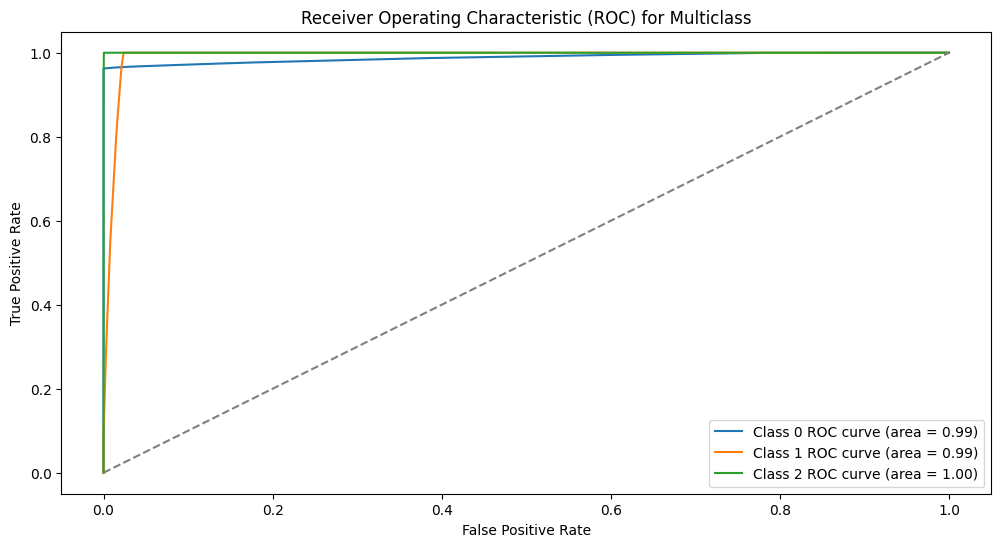

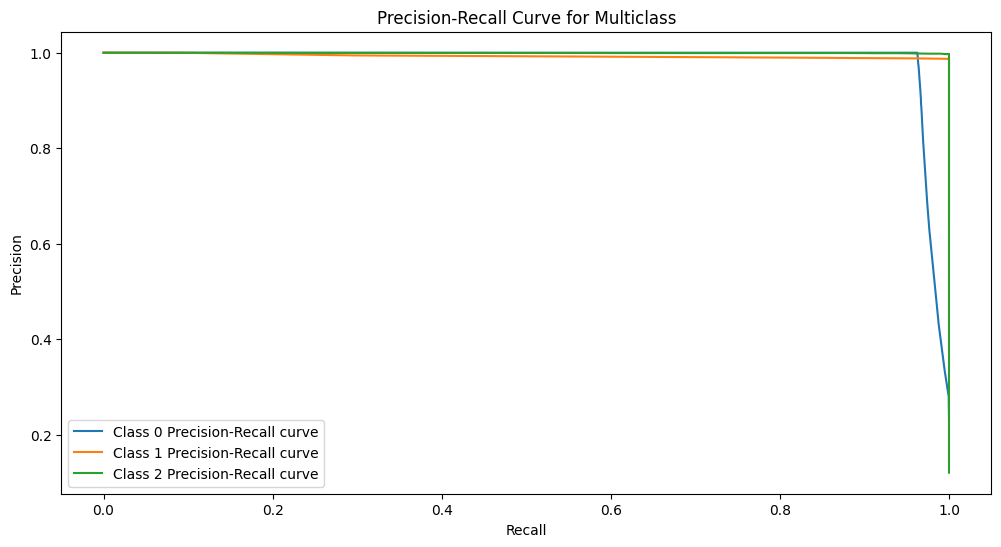

In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Binarize the labels for multiclass classification (One-vs-Rest)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # Change this to match the number of classes you have
n_classes = y_test_bin.shape[1]

# Get probabilities for each class
y_pred_proba = rf_model.predict_proba(X_test)

# Initialize plots
plt.figure(figsize=(12, 6))

# Plot ROC curve for each class
for i in range(n_classes):
    fpr, tpr, thresholds = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} ROC curve (area = {roc_auc:.2f})')

# Plot ROC curve for the random classifier (diagonal line)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the ROC plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multiclass')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 6))
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_proba[:, i])
    plt.plot(recall, precision, label=f'Class {i} Precision-Recall curve')

# Customize the Precision-Recall plot
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multiclass')
plt.legend(loc='lower left')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd

# Define parameter grid for Random Forest
param_grid = {
    'n_estimators': [100],
    'max_depth': [10],
    'min_samples_split': [2],
    'min_samples_leaf': [1]
}

# GridSearch for Random Forest
grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Best parameters and cross-validation score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Score:", grid_search.best_score_)

# Evaluate the best model
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calculate and print metrics
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Cross-Validation Score: 0.9912298108922052
Test Accuracy: 0.9912116958365689
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     31349
         1.0       0.99      1.00      0.99     86430
         2.0       1.00      1.00      1.00     16149

    accuracy                           0.99    133928
   macro avg       0.99      0.99      0.99    133928
weighted avg       0.99      0.99      0.99    133928

Confusion Matrix:
 [[30173  1129    47]
 [    0 86430     0]
 [    1     0 16148]]


In [ ]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define pipeline with SMOTE and model
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', RandomForestClassifier(class_weight='balanced', random_state=42))
])

# Correct parameter grid (note the "model__" prefix)
param_grid = {
    'model__n_estimators': [400],  # <-- Add "model__"
    'model__max_depth': [30],        # <-- Add "model__"
    'model__min_samples_split': [5],
    'model__min_samples_leaf': [2],
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=10,
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit the model
random_search.fit(X_train, y_train)

# Print best parameters
print("Best Hyperparameters:", random_search.best_params_)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'model__n_estimators': 400, 'model__min_samples_split': 5, 'model__min_samples_leaf': 2, 'model__max_depth': 30}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate precision, recall, and F1-score
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# You can also print a classification report for more detailed information
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

# And a confusion matrix to visualize the performance
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Precision: 0.9912977642794311
Recall: 0.9911892957409951
F1-score: 0.9911329824348345
              precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     31349
         1.0       0.99      1.00      0.99     86430
         2.0       1.00      1.00      1.00     16149

    accuracy                           0.99    133928
   macro avg       0.99      0.99      0.99    133928
weighted avg       0.99      0.99      0.99    133928

Confusion Matrix:
[[30173  1129    47]
 [    0 86430     0]
 [    4     0 16145]]


In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Define model
model = RandomForestClassifier(random_state=42)

# Perform stratified 5-fold cross-validation
cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
cv_scores_f1 = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')

# Print results
print(f'Cross-validation accuracy scores: {cv_scores}')
print(f'Mean cross-validation accuracy: {cv_scores.mean()}')

print(f'Cross-validation F1-score: {cv_scores_f1}')
print(f'Mean cross-validation F1-score: {cv_scores_f1.mean()}')

Cross-validation accuracy scores: [0.9911669  0.99101009 0.99101009 0.9914805  0.99167457]
Mean cross-validation accuracy: 0.9912684303126589
Cross-validation F1-score: [0.99110988 0.99095178 0.99095122 0.99142753 0.99162403]
Mean cross-validation F1-score: 0.9912128869549829


In [ ]:
import joblib

# Save the Random Forest model
with open('rf_model.joblib', 'wb') as file:
    joblib.dump(rf_model, file)

strength
1.0    432151
0.0    156745
2.0     80743
Name: count, dtype: int64


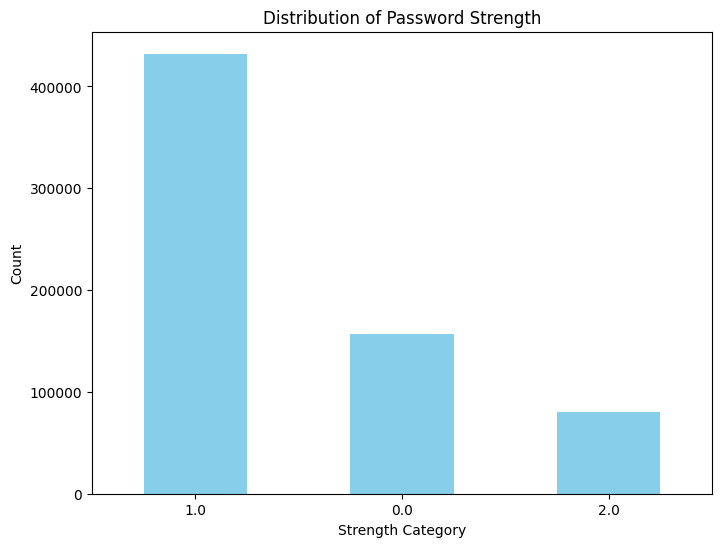

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'data' and the target column is 'strength'
strength_counts = data['strength'].value_counts()

# Print the value counts
print(strength_counts)

# Create a bar plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed
strength_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Password Strength')
plt.xlabel('Strength Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Keep x-axis labels horizontal
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Assuming 'X' is your feature matrix and 'y' is your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Retrain model
model.fit(X_train, y_train)

# Evaluate on training and testing sets
train_accuracy = accuracy_score(y_train, model.predict(X_train))
test_accuracy = accuracy_score(y_test, model.predict(X_test))

# Check accuracy again
print(f"Training Accuracy (after fix): {train_accuracy}")
print(f"Testing Accuracy (after fix): {test_accuracy}")

Training Accuracy (after fix): 0.9911146098001694
Testing Accuracy (after fix): 0.9916671644465683


Training Accuracy: 0.9911146098001694
Testing Accuracy: 0.9916671644465683
The model's performance is consistent.


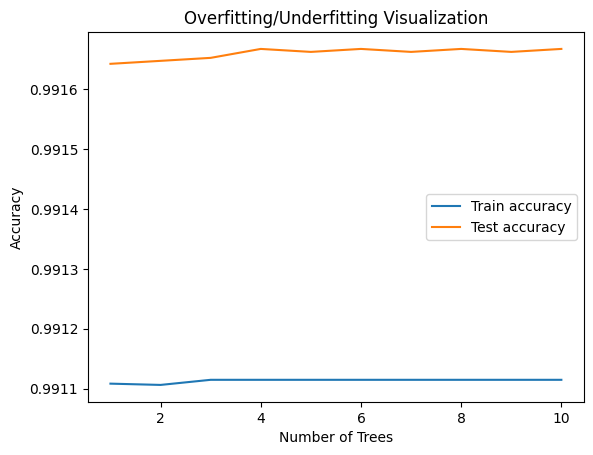

In [ ]:
# prompt: code to check data leakage

# Assuming 'model' is your trained model, and 'X_train', 'X_test', 'y_train', 'y_test' are defined
# as in your previous code.

# Predict on training and testing data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate accuracy on training and testing data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Output the accuracy
print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

# Check for overfitting or underfitting with a threshold
if train_accuracy > test_accuracy + 0.1:  # Added a threshold of 0.1
    print("The model might be overfitting.")
elif test_accuracy > train_accuracy + 0.1:  # Added a threshold of 0.1
    print("The model might be underfitting.")
else:
    print("The model's performance is consistent.")

# Visualize the training and testing accuracies as a function of model complexity
# This example uses n_estimators, but replace with any relevant hyperparameter you're tuning

train_accuracies = []
test_accuracies = []
n_estimators_range = range(1, 11)  # Example: Varying n_estimators from 1 to 10

for n_estimators in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=42)
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

plt.plot(n_estimators_range, train_accuracies, label='Train accuracy')
plt.plot(n_estimators_range, test_accuracies, label='Test accuracy')
plt.legend()
plt.title("Overfitting/Underfitting Visualization")
plt.xlabel("Number of Trees")
plt.ylabel("Accuracy")
plt.show()


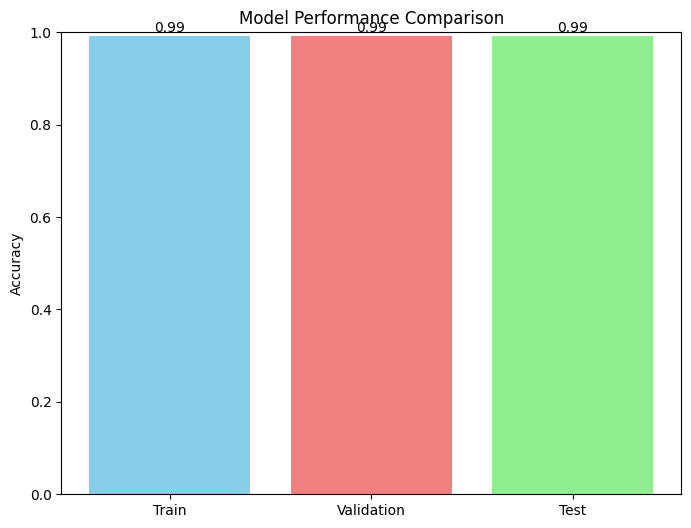

In [ ]:
import matplotlib.pyplot as plt


# Calculate accuracy for train, validation, and test sets
train_accuracy = accuracy_score(y_train, rf_model.predict(X_train))
val_accuracy = accuracy_score(y_val, rf_model.predict(X_val))
test_accuracy = accuracy_score(y_test, rf_model.predict(X_test))

# Create a bar plot to compare accuracies
data = {'Train': train_accuracy, 'Validation': val_accuracy, 'Test': test_accuracy}
names = list(data.keys())
values = list(data.values())

plt.figure(figsize=(8, 6))
plt.bar(names, values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Set y-axis limits to 0 and 1
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center') # Added text labels for each bar
plt.show()


# **SVM**

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

# If you have DataFrames and a list of selected feature names:
X_train_sel = X_train[selected_features]
X_test_sel  = X_test[selected_features]

# Build an SVM pipeline with feature scaling
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm',    SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42))
])

# Train SVM models
svm_pipeline.fit(X_train_sel, y_train)

# Predict and evaluate
y_pred_svm = svm_pipeline.predict(X_test_sel)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Classification Report:\n", classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.9901937359377178
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.96      0.98     47062
         1.0       0.99      1.00      0.99    129487
         2.0       1.00      1.00      1.00     24343

    accuracy                           0.99    200892
   macro avg       0.99      0.99      0.99    200892
weighted avg       0.99      0.99      0.99    200892



In [ ]:
# Save the model
joblib.dump(svm_pipeline, 'svm_model.joblib')

['svm_model.joblib']

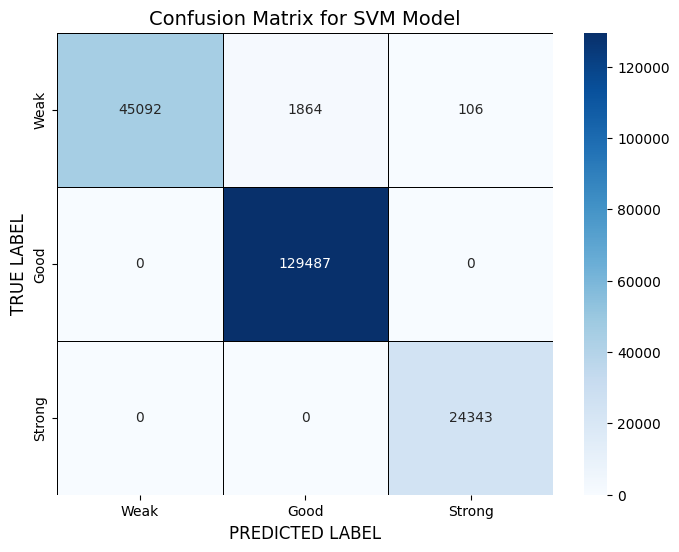

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 3. Train and predict
svm_pipeline.fit(X_train_sel, y_train)
svm_predictions = svm_pipeline.predict(X_test)

#Compute confusion matrix
cm = confusion_matrix(y_test, svm_predictions)
labels = ["Weak", "Good", "Strong"]

#Plot
plt.figure(figsize=(8, 6), facecolor='w')
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='black',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("PREDICTED LABEL", fontsize=12)
plt.ylabel("TRUE LABEL", fontsize=12)
plt.title("Confusion Matrix for SVM Model", fontsize=14)
plt.show()


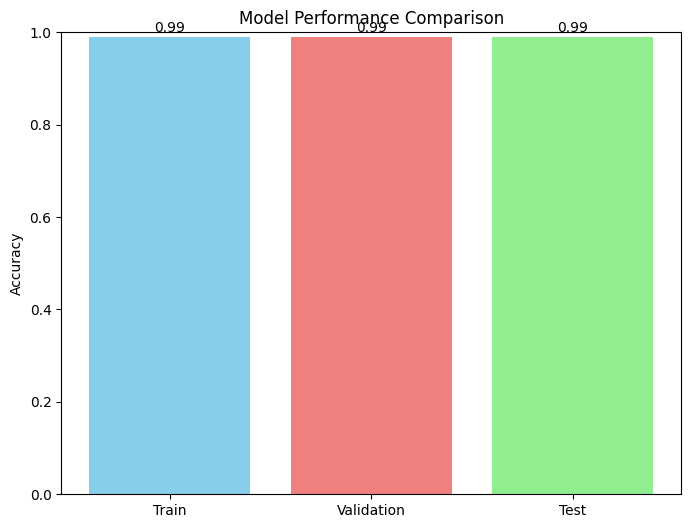

In [ ]:
import matplotlib.pyplot as plt


# Calculate accuracy for train, validation, and test sets
train_accuracy = accuracy_score(y_train, svm_pipeline.predict(X_train))
val_accuracy = accuracy_score(y_val, svm_pipeline.predict(X_val))
test_accuracy = accuracy_score(y_test, svm_pipeline.predict(X_test))

# Create a bar plot to compare accuracies
data = {'Train': train_accuracy, 'Validation': val_accuracy, 'Test': test_accuracy}
names = list(data.keys())
values = list(data.values())

plt.figure(figsize=(8, 6))
plt.bar(names, values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Set y-axis limits to 0 and 1
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center') # Added text labels for each bar
plt.show()


# **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

#Extract the same selected features
selected_features = ['length', 'num_upper', 'char_variety_score', 'entropy', 'pattern_detect']
X_train_sel = X_train[selected_features]
X_test_sel  = X_test[selected_features]

#Build a pipeline with scaling + logistic regression
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr',     LogisticRegression(
                   penalty='l2',
                   C=1.0,
                   solver='lbfgs',
                   max_iter=500,
                   random_state=42
               ))
])

#Train the logistic regression model
lr_pipeline.fit(X_train_sel, y_train)

# 4. Predict and evaluate
y_pred_lr = lr_pipeline.predict(X_test_sel)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.9022061605240627
Classification Report:
               precision    recall  f1-score   support

         0.0       0.94      0.62      0.75     47062
         1.0       0.88      0.98      0.93    129487
         2.0       0.99      1.00      1.00     24343

    accuracy                           0.90    200892
   macro avg       0.94      0.87      0.89    200892
weighted avg       0.91      0.90      0.90    200892



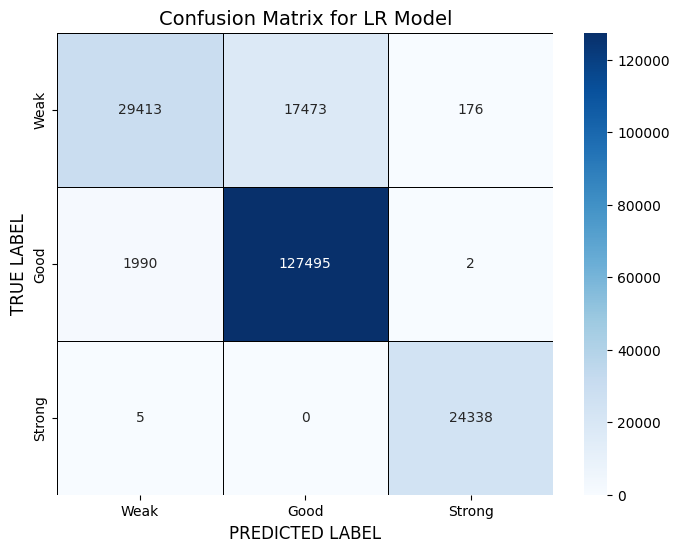

In [ ]:
#Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
labels = ["Weak", "Good", "Strong"]

#Plot
plt.figure(figsize=(8, 6), facecolor='w')
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    linewidths=0.5,
    linecolor='black',
    cmap='Blues',
    xticklabels=labels,
    yticklabels=labels
)
plt.xlabel("PREDICTED LABEL", fontsize=12)
plt.ylabel("TRUE LABEL", fontsize=12)
plt.title("Confusion Matrix for LR Model", fontsize=14)
plt.show()


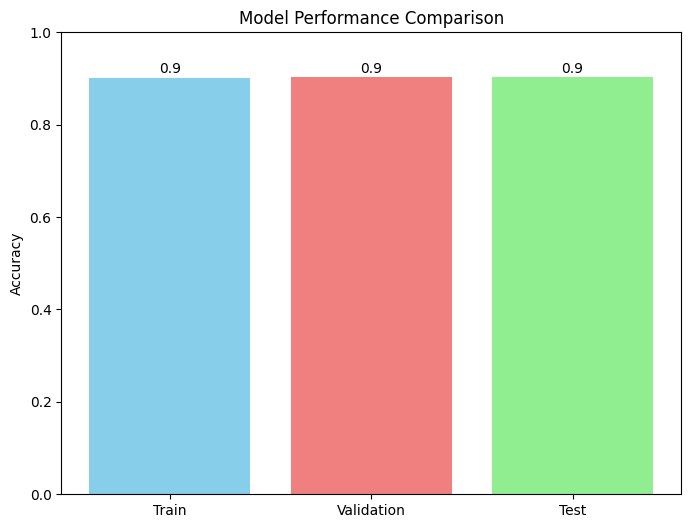

In [ ]:
import matplotlib.pyplot as plt


# Calculate accuracy for train, validation, and test sets
train_accuracy = accuracy_score(y_train, lr_pipeline.predict(X_train))
val_accuracy = accuracy_score(y_val, lr_pipeline.predict(X_val))
test_accuracy = accuracy_score(y_test, lr_pipeline.predict(X_test))

# Create a bar plot to compare accuracies
data = {'Train': train_accuracy, 'Validation': val_accuracy, 'Test': test_accuracy}
names = list(data.keys())
values = list(data.values())

plt.figure(figsize=(8, 6))
plt.bar(names, values, color=['skyblue', 'lightcoral', 'lightgreen'])
plt.title('Model Performance Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1) # Set y-axis limits to 0 and 1
for i, v in enumerate(values):
    plt.text(i, v + 0.01, str(round(v, 2)), ha='center') # Added text labels for each bar
plt.show()


In [ ]:
import joblib

# Save the LR model
with open('lr_pipeline.joblib', 'wb') as file:
    joblib.dump(lr_pipeline, file)

# **CNN**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#Prepare data
data = pd.read_csv('/content/password-strength-classifier-dataset/data.csv', on_bad_lines='skip')
data = data.dropna().drop_duplicates()

# Extract texts and labels
texts = data['password'].astype(str).values
labels = data['strength'].astype(int).values  # assume [0,1,2]

# Encode labels as one-hot
encoder = LabelEncoder()
labels_enc = encoder.fit_transform(labels)
y = to_categorical(labels_enc)    # shape (n_samples, 3)

# Split into train/test
X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts, y, test_size=0.25, random_state=42, stratify=y
)

#Tokenize at character level
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(X_train_text)
vocab_size = len(tokenizer.word_index) + 1  # include padding token

# Convert texts to padded integer sequences
maxlen = 20   # maximum password length to consider (pad/truncate to this)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train_text),
                            maxlen=maxlen, padding='post', truncating='post')
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test_text),
                            maxlen=maxlen, padding='post', truncating='post')

#Build the 1D CNN model
embedding_dim = 50

model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              input_length=maxlen),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

#Train CNN model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(
    X_train_seq, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=64,
    callbacks=[early_stop]
)

#Evaluate on the test set
loss, acc = model.evaluate(X_test_seq, y_test, verbose=0)
print(f'Test Accuracy: {acc:.4f}')

#Detailed classification report
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_seq)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

print(classification_report(
    y_true_labels,
    y_pred_labels,
    target_names=encoder.classes_.astype(str)
))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ ?                      │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - accuracy: 0.8461 - loss: 0.3865 - val_accuracy: 0.9186 - val_loss: 0.1861
Epoch 2/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 78s 9ms/step - accuracy: 0.8981 - loss: 0.2499 - val_accuracy: 0.9343 - val_loss: 0.1578
Epoch 3/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.9086 - loss: 0.2245 - val_accuracy: 0.9343 - val_loss: 0.1598
Epoch 4/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 65s 9ms/step - accuracy: 0.9128 - loss: 0.2129 - val_accuracy: 0.9292 - val_loss: 0.1599
Epoch 5/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 65s 9ms/step - accuracy: 0.9161 - loss: 0.2064 - val_accuracy: 0.9409 - val_loss: 0.1402
Epoch 6/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 80s 9ms/step - accuracy: 0.9161 - loss: 0.2039 - val_accuracy: 0.9485 - val_loss: 0.1384
Epoch 7/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 63s 9ms/step - accuracy: 0.9182 - loss: 0.1987 - val_accuracy: 0.9396 - val_loss: 0.1416
Epoch 8/20
7063/7063 ━━━━━━━━━━━━━━━━━━━━ 65s 9ms/step - accuracy: 0.9198 - loss: 0

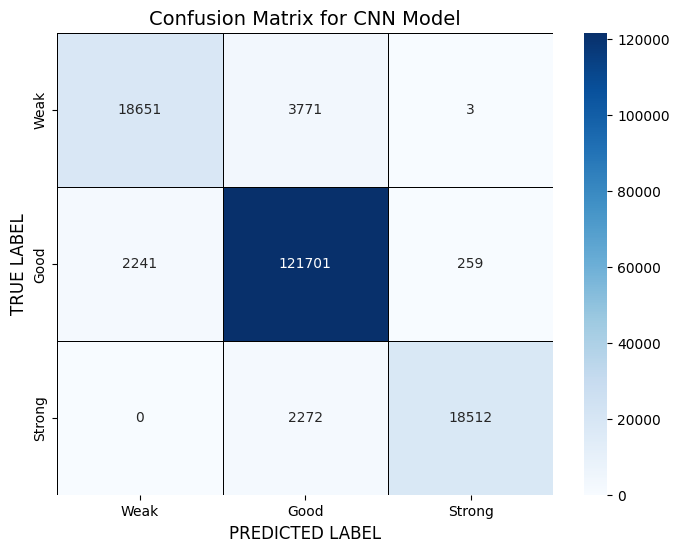

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
import pandas as pd


# Compute confusion matrix for CNN
cm_cnn = confusion_matrix(y_true_labels, y_pred_labels)

# Define labels for the confusion matrix (assuming 0: Weak, 1: Good, 2: Strong)
# Make sure these labels match your encoded labels and the order in your data
labels_cnn = ["Weak", "Good", "Strong"]

# Plot confusion matrix using seaborn
plt.figure(figsize=(8, 6), facecolor='w')
sns.heatmap(cm_cnn, annot=True, linewidths=0.5, linecolor="black", fmt="d",
            cmap="Blues", xticklabels=labels_cnn, yticklabels=labels_cnn)

# Add labels and title
plt.xlabel("PREDICTED LABEL", fontsize=12)
plt.ylabel("TRUE LABEL", fontsize=12)
plt.title("Confusion Matrix for CNN Model", fontsize=14)

# Display the plot
plt.show()

In [ ]:
model.save('cnn_model.keras')

# **Evaluation**

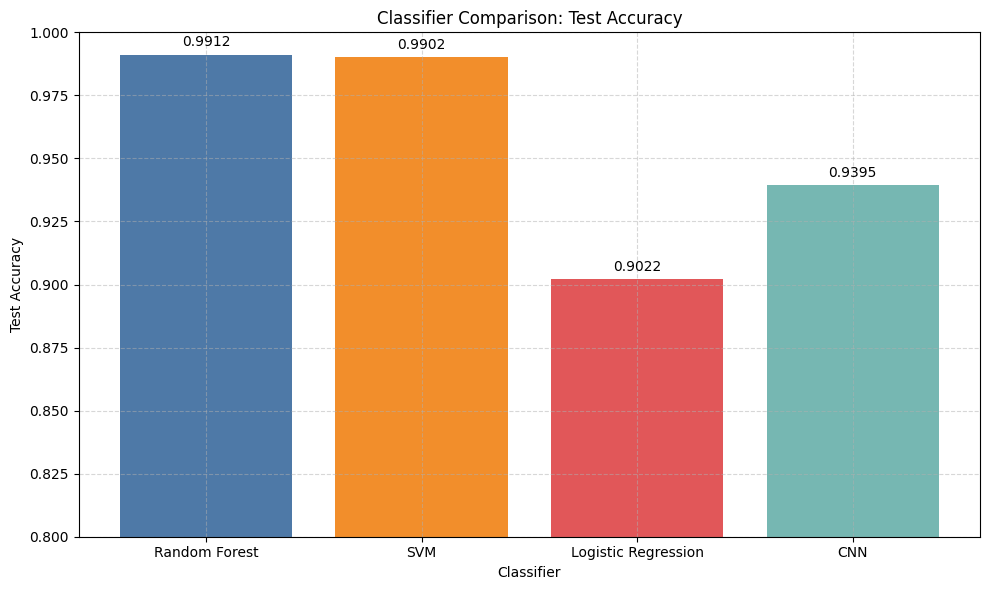

In [ ]:
import matplotlib.pyplot as plt

# Define classifier names and their test accuracies based on data from your file
classifiers = ['Random Forest', 'SVM', 'Logistic Regression', 'CNN']
accuracies = [
    0.9912,   # Random Forest - from classification report
    0.9902,   # SVM - from classification report
    0.9022,   # Logistic Regression - from classification report
    0.9395    # CNN - from final evaluation in model output
]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
bars = plt.bar(classifiers, accuracies, color=['#4E79A7', '#F28E2B', '#E15759', '#76B7B2'])

# Add accuracy labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.002, f'{yval:.4f}', ha='center', va='bottom')

# Customize plot appearance
plt.title('Classifier Comparison: Test Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Test Accuracy')
plt.ylim(0.8, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)

# Show plot
plt.tight_layout()
plt.show()